<h1 style="text-align:center;"><b>Easy Data Augmentation (EDA) for Text Classification with Disaster Tweets</b></h1>

<h2 style="text-align:center;"><b>Course: Introduction to Natural Language Processing</b></h2>

<h3 style="text-align:center;"><b>University of Trento, 2021-22</b></h3>


# 0. Instructions

The notebook is divided into the following sections:
- **1. Setup** 
    - ***1.1 Import libraries***: import the required libraries
    - ***1.2 Set random seed***: set the random seed for reproducibility
- **2. Dataset**
    - ***2.1 Load and prepare Disaster Tweets dataset***: load the dataset and prepare it for the experiments
    - ***2.2 Resampling***: resample the dataset  (optional)
- **3. Data Preprocessing**
    - ***3.1 Cleaning***: clean the tweets
    - ***3.2 EDA: Easy Data Augmentation***: apply EDA to the tweets (optional)
    - ***3.3 Tokenization and Padding***: tokenize and pad the tweets
    - ***3.4 GloVe Embeddings***: load the GloVe embeddings and prepare the embedding matrix for the RNN model
- **4. RNN with LSTM cells**
    - ***4.1 Define the RNN model***: define the RNN model
    - ***4.2 Train and evaluate the RNN model***

Follow the instructions in the notebook to run the code. 
Remember that if you want to resample the dataset, you have to run the cells in the ***Resampling*** section. Otherwise, you can skip them.
Remember that if you want to use EDAs, you have to run the cells in the ***EDA*** section. Otherwise, you can skip them.

# 1. Setup

# 1.1 Import libraries

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import os

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# sklearn nlp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# keras
import tensorflow as tf

# utils
from utils import save_metrics, print_metrics, plot_confusion_matrix

# preprocessing
from preprocessing import preprocess_data

# # data augmentation
from data_augmentation import augment_data

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ivand\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1.2 Set random seed and create useful folders

In [2]:
def set_seed(seed = 16):
    np.random.seed(16)
    tf.random.set_seed(16)

set_seed()

# create a folder called saved_results if it does not exist
if not os.path.exists('saved_results'):
    os.mkdir('saved_results')
    print('saved_results folder created')
else:
    print('saved_results folder already exists')

saved_results folder already exists


# 2. Dataset

# 2.1 Load and prepare Disaster Tweets dataset
Description: This dataset contains 7613 tweets that were hand classified as disaster or not disaster. The dataset is unbalanced, with only 3271 non-disaster tweets and 4342 disaster tweets. The goal is to predict which tweets are about real disasters and which one’s aren’t.

In [3]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
# drop unnecessary columns
df.drop(['id','keyword','location'],axis=1,inplace=True)
df.head(3)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1


In [5]:
# print if there are any missing values
print('There are {} missing values in the dataset'.format(df.isnull().sum().sum()))

# print the number of rows and columns in the dataset
print('There are {} rows and {} columns in the dataset'.format(df.shape[0],df.shape[1]))

# print the names of the columns
print('The names of the columns are: {}'.format(df.columns))

# print the number of tweets per class
print('The number of tweets per class are: ')
print('{}'.format(df.target.value_counts()))

There are 0 missing values in the dataset
There are 7613 rows and 2 columns in the dataset
The names of the columns are: Index(['text', 'target'], dtype='object')
The number of tweets per class are: 
0    4342
1    3271
Name: target, dtype: int64


## 2.2 Resampling
Disclaimer: use this code to resample the dataset if you want to use a balanced dataset. Otherwise, skip this cell.

In [6]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.target==0]
df_minority = df[df.target==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df = df_downsampled.copy()

# reset the index
df.reset_index(drop=True,inplace=True)

# print the number of tweets per class
print('The number of tweets per class are: ')
print('{}'.format(df.target.value_counts()))

The number of tweets per class are: 
0    3271
1    3271
Name: target, dtype: int64


# 3. Data Preprocessing

# 3.1 Cleaning

In [7]:
# apply preprocess_data function to the text column
df['clean_text'] = df['text'].apply(lambda x: preprocess_data(x))
df.head(3)

,text,target,clean_text
0,My ear started bleeding again...,0,ear start bleed
1,Dying with debt can be costly for survivors,0,die debt cost survivor
2,@TromboneTristan OOOOOHSHIT OOOHSHIT SCREAMS h...,0,trombonetristan ooooohshit ooohshit scream hel...


In [8]:
# compare the original text with the clean text print the first 3 rows
print(df[['text','clean_text']].head(3))

                                                text  \
0                   My ear started bleeding again...   
1        Dying with debt can be costly for survivors   
2  @TromboneTristan OOOOOHSHIT OOOHSHIT SCREAMS h...   

                                          clean_text  
0                                    ear start bleed  
1                             die debt cost survivor  
2  trombonetristan ooooohshit ooohshit scream hel...  


In [9]:
# Split the data into train and test sets

df = df[['clean_text','target']]

# rename the column clean_text to text
df.rename(columns={'clean_text':'text'},inplace=True)


# split the data into train and validation set keeping the dataframe structure with text and target

df_train, df_test = train_test_split(df, test_size=0.2, random_state=16)

# print the shape of the train and validation set

print('There are {} rows and {} columns in train'.format(df_train.shape[0],df_train.shape[1]))
print('There are {} rows and {} columns in validation'.format(df_test.shape[0],df_test.shape[1]))

There are 5233 rows and 2 columns in train
There are 1309 rows and 2 columns in validation


## 3.2 EDA: Easy Data Augmentation

In the following section, we will use the textattack library to augment our training data. We will use the EDA (Easy Data Augmentation) technique to augment our training data. The EDA technique is a simple yet effective data augmentation technique that can be used to increase the size of our training data. The technique is based on the following steps:
- Randomly choose n words from the sentence.
- Synonym replacement: Replace each of the n words with one of its synonyms chosen at random.
- Random insertion: Insert n random words at random positions in the sentence.
- Random swap: Randomly swap pairs of words in the sentence n times.

### Methodology

We will apply the EDA technique to our training data. We will use the following parameters:
- n: 4
- alpha: 0.1

From each sentence, we will generate 4 augmented sentences. We will use the alpha parameter to control the number of words that will be replaced, inserted or swapped. The alpha parameter is a float value between 0 and 1. The higher the value of alpha, the more words will be replaced, inserted or swapped.

### Disclaimer: Data Augmentation
You use the following cells if you want to perform the classification task applying the EDA technique. If you want to use just the original dataset, you can skip the following cells.


In [ ]:
# # print shape of train and test

# print('There are {} rows and {} columns in train'.format(df_train.shape[0],df_train.shape[1]))
# print('There are {} rows and {} columns in validation'.format(df_test.shape[0],df_test.shape[1]))

In [ ]:
# # perform data augmentation on the train set
# df_train = augment_data(df_train, pct_words_to_swap=0.1, transformations_per_example=4)

In [ ]:
# print('There are {} rows and {} columns in train'.format(df_train.shape[0],df_train.shape[1]))
# print('There are {} rows and {} columns in validation'.format(df_test.shape[0],df_test.shape[1]))

# 3.3 Tokenization and Padding

In [10]:
# create x_train, y_train, x_val, y_val

x_train, y_train = df_train['text'], df_train['target']
x_test, y_test = df_test['text'], df_test['target']

In [11]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

max_length = 30

from tensorflow.keras.preprocessing.sequence import pad_sequences
# The tokens are converted into sequences and then passed to the pad_sequences() function
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),maxlen = max_length)

# print shapes
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Vocabulary Size : 10687
x_train shape: (5233, 30)
x_test shape: (1309, 30)


# 3.4 GloVe Embeddings

In [12]:
embeddings_index = {}
# opening the downloaded glove embeddings file
embedding_dimension = 300
f = open('data/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [13]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, embedding_dimension))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

# 4. RNN with LSTM cells

## 4.1 Define the RNN model

In [14]:
# create a folder called Glove_LSTM inside the saved_results folder if it does not exist

if not os.path.exists('saved_results/Glove_LSTM'):
    os.mkdir('saved_results/Glove_LSTM')
    print('saved_results/Glove_LSTM folder created')
else:
    print('saved_results/Glove_LSTM folder already exists')


# create a folder AUG_Glove_LSTM inside the saved_results/Glove_LSTM folder if it does not exist

if not os.path.exists('saved_results/Glove_LSTM/AUG_Glove_LSTM'):
    os.mkdir('saved_results/Glove_LSTM/AUG_Glove_LSTM')
    print('saved_results/Glove_LSTM/AUG_Glove_LSTM folder created')

else:
    print('saved_results/Glove_LSTM/AUG_Glove_LSTM folder already exists')

saved_results/Glove_LSTM folder created
saved_results/Glove_LSTM/AUG_Glove_LSTM folder created


In [15]:
import tensorflow as tf
embedding_layer = tf.keras.layers.Embedding(vocab_size,embedding_dimension,
                                            weights=[embedding_matrix],
                                          input_length=max_length,trainable=False)


# Import various layers needed for the architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

# The Input layer 
sequence_input = Input(shape=(max_length,), dtype='int32')
# Inputs passed to the embedding layer
embedding_sequences = embedding_layer(sequence_input)
# Passed on to the bi-directional LSTM layer
x = Bidirectional(LSTM(64, return_sequences=True))(embedding_sequences)
x = Dropout(0.5)(x)
# Passed on to the second bi-directional LSTM layer
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.5)(x)
# Passed on to dense layer with ReLU activation
x = Dense(20, activation='relu')(x)
# Passed on to sigmoid output layer
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

# Compile the model with binary crossentropy loss function and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping with a patience of 3 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           3206100   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          186880    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

## 4.2 Train and evaluate the RNN model

In [17]:
# Train the model
training = model.fit(x_train, y_train, batch_size=1024, epochs=50,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
6/6 [==============================] - 14s 1s/step - loss: 0.6835 - accuracy: 0.5821 - val_loss: 0.6543 - val_accuracy: 0.7227
Epoch 2/50
6/6 [==============================] - 5s 761ms/step - loss: 0.6311 - accuracy: 0.7181 - val_loss: 0.5828 - val_accuracy: 0.7349
Epoch 3/50
6/6 [==============================] - 5s 794ms/step - loss: 0.5619 - accuracy: 0.7458 - val_loss: 0.5519 - val_accuracy: 0.7303
Epoch 4/50
6/6 [==============================] - 5s 840ms/step - loss: 0.5246 - accuracy: 0.7600 - val_loss: 0.5398 - val_accuracy: 0.7502
Epoch 5/50
6/6 [==============================] - 5s 804ms/step - loss: 0.4982 - accuracy: 0.7743 - val_loss: 0.5187 - val_accuracy: 0.7532
Epoch 6/50
6/6 [==============================] - 5s 812ms/step - loss: 0.4838 - accuracy: 0.7797 - val_loss: 0.5097 - val_accuracy: 0.7594
Epoch 7/50
6/6 [==============================] - 5s 784ms/step - loss: 0.4705 - accuracy: 0.7875 - val_loss: 0.5153 - val_accuracy: 0.7532
Epoch 8/50
6/6 [======

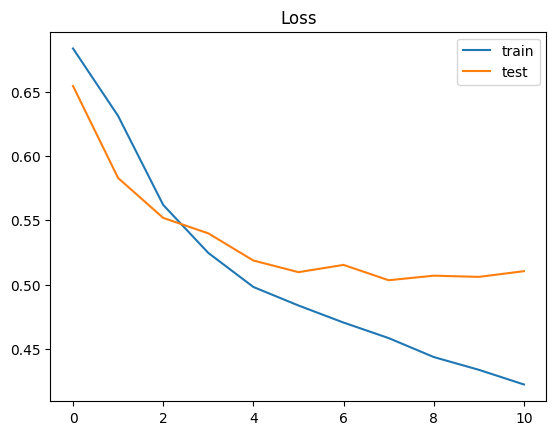

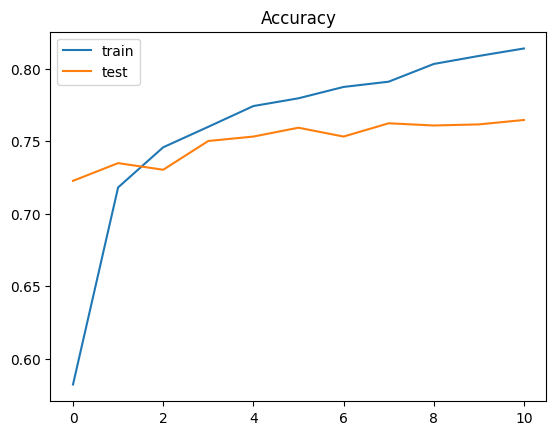

In [18]:
from utils import plot_and_save_loss
from utils import plot_and_save_accuracy

# Plotting the training and validation loss

plot_and_save_loss(training, 'saved_results/Glove_LSTM/loss.png') 
# plot_and_save_loss(training, 'saved_results/Glove_LSTM/AUG_Glove_LSTM/loss.png')

# Plotting the training and validation accuracy

plot_and_save_accuracy(training, 'saved_results/Glove_LSTM/accuracy.png')
# plot_and_save_accuracy(training, 'saved_results/Glove_LSTM/AUG_Glove_LSTM/accuracy.png')


41/41 [==============================] - 2s 15ms/step
F1-score:  0.7479541734860884
Precision:  0.8031634446397188
Recall:  0.6998468606431854
Acuracy:  0.7647058823529411

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       656
           1       0.80      0.70      0.75       653

    accuracy                           0.76      1309
   macro avg       0.77      0.76      0.76      1309
weighted avg       0.77      0.76      0.76      1309



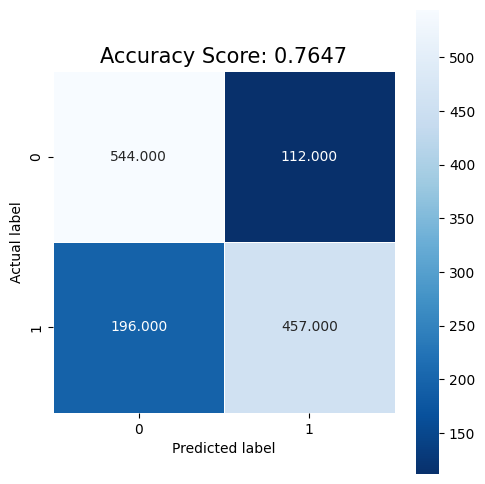

In [19]:
# Predicting the test data
y_pred = model.predict(x_test)

# Converting the predicted values to 0 or 1
y_pred = np.round(y_pred)

print_metrics(y_test, y_pred)

plot_confusion_matrix(y_test, y_pred, 'saved_results/Glove_LSTM/Glove_LSTM_Confusion_Matrix.png')
# plot_confusion_matrix(y_test, y_pred, 'saved_results/Glove_LSTM/AUG_Glove_LSTM/Glove_LSTM_Confusion_Matrix.png')


save_metrics(y_test, y_pred, 'saved_results/Glove_LSTM')
# save_metrics(y_test, y_pred, 'saved_results/Glove_LSTM/AUG_Glove_LSTM')